## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
import xgboost as xg
import lightgbm as lgb

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

from variables import feriados_2015, feriados_2018, vesperas_2015, vesperas_2018, feriados_2020, vesperas_2020

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [ ]:
year = 2015

if (year == 2015):
    feriados = feriados_2015
    vesperas = vesperas_2015
    data = pd.read_csv('../data_input_zerofill_2015.csv', delimiter=";")
elif (year == 2018):
    feriados = feriados_2018
    vesperas = vesperas_2018
    data = pd.read_csv('../data_input_zerofill_2018.csv', delimiter=",")
elif (year == 2020):
    feriados = feriados_2020
    vesperas = vesperas_2020
    data = pd.read_csv('../data_input_zerofill_2020.csv', delimiter=";")


In [ ]:


data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
data_model = data.loc[data.data_hora.dt.year == year].copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    # 'hora',
    'hour_sin',
    'hour_cos',
    'd_mes',
    'd_ano',
    'mes',
    'semana_do_mes',
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado',
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

busline_filter = 41

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

top100_linhas = data_model.groupby(data_model.linha).sum().reset_index().sort_values('validations_per_hour', ascending=False).index[:100].to_list()
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)]

top100_linhas_data_model.to_csv("../dados-para-modelos/2015/top100_linhas_data_model_2015.csv", index=False)
line_data_model = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == busline_filter].copy()

#sns.set(rc={'figure.figsize':(15,10)})
# sns.heatmap(top100_linhas_data_model.corr()[['validations_per_hour']].sort_values(by='validations_per_hour', ascending=False)
# , vmin=-1, vmax=1, annot=True)

In [ ]:
line_data_model

In [ ]:
#display(X)

In [ ]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [ ]:
# Per Line Data

X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [ ]:
model_list = []

In [ ]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict) * 100
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [ ]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [ ]:
# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

#### Random Forest Model Parameters

In [ ]:
# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

# Grid Searched

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearched_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)

GridSearchedRandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DefaultRandomForestModelPipeline = make_pipeline(default_randomforest_model)


In [ ]:
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)
performance_gridsearched_linearregression_model = get_performance(gridsearched_random_linearregression)
performance_default_linearregression_model = get_performance(default_linearregression_model)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE', 'MAPE'], 
    index=['Regressao Linear Default', 'RandomForest Default', 'Regressao Linear Grid Searched', 'RandomForest GridSearched'])
performance_total

In [ ]:
RidgeRegressionModel = Ridge(alpha=.5)
ridge = RidgeRegressionModel.fit(X_train, Y_train)
performance_ridge = get_performance(ridge)
df2 = pd.DataFrame([performance_ridge], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Ridge Regression'])
performance_total = pd.concat([df2, performance_total])


In [ ]:
DecitionTreeModel = DecisionTreeRegressor()
dtm = DecitionTreeModel.fit(X_train, Y_train)
performance_dtm = get_performance(dtm)
df2 = pd.DataFrame([performance_dtm], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Arvore de Decisao'])
performance_total = pd.concat([df2, performance_total])


In [ ]:
SVRModel = SVR()
svr = SVRModel.fit(X_train, Y_train)
performance_SVR = get_performance(svr)
df2 = pd.DataFrame([performance_SVR], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['SVR Regression'])
performance_total = pd.concat([df2, performance_total])

# BAGGING

In [ ]:
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(gridsearched_random_linearregression)
RandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DecisionTreeModelPipeline = make_pipeline(dtm)

bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)
bagging_dt_model, performance_bagging_dt_model = bagging_model(DecisionTreeModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model, performance_bagging_dt_model], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Regressao Linear Bagging', 'RandomForest Bagging', 'Decision Tree Bagging'])
performance_total = pd.concat([df2, performance_total])

BaggingLinearRegressionModelPipeline = make_pipeline(bagging_lr_model)
BaggingRandomForestModelPipeline = make_pipeline(bagging_rf_model)
BaggingDecisionTreeModelPipeline = make_pipeline(bagging_dt_model)



In [ ]:
performance_total.sort_values('MAE')

# BOOSTING

In [ ]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['GradientBoostingRegressor'])

GradientBoostingModelPipeline = make_pipeline(gradient_boosting_regressor)

performance_total = pd.concat([df2, performance_total])


# STACKING

In [22]:
estimators = [
    ('gridseached_randomforest', GridSearchedRandomForestModelPipeline),
    ('bagging_randomforest',BaggingRandomForestModelPipeline),
    ('gradient_boosting', GradientBoostingModelPipeline),
    ('random_forest_default', DefaultRandomForestModelPipeline)
]

stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegressionModelPipeline, cv= 5, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])

# extreme Gradient Boosting

In [23]:
xgb_r = xg.XGBRegressor(n_estimators = 100, seed = 42, eval_metric='mae', booster='gbtree')

In [24]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     #default_linearregression_model,
#     #gridsearched_result_linearregression,
#     #gridsearched_random_randomforest,
#     #bagging_lr_model,
# ]

sample = X.sample(n=1)
sample

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

display(data_model.loc[sample.index])

res = stack.predict(sample)
print("Stacked Regressor -> resultado do predict de test: ", res)

res = gradient_boosting_regressor.predict(sample)
print("gradient_boosting_regressor -> resultado do predict de test: ", res)

res = bagging_rf_model.predict(sample)
print("bagging_rf_model -> resultado do predict de test: ", res)

res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", res)

res = default_randomforest_model.predict(sample)
print("Random Forest Default -> resultado do predict de test: ", res)

res = bagging_lr_model.predict(sample)
print("bagging_lr_model -> resultado do predict de test: ", res)

res = default_linearregression_model.predict(sample)
print("Regressao Linear Default -> resultado do predict de test: ", res)

res = gridsearched_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", res)

LINHA UTILIZADA PARA OS TESTES:  41

Utilizando sample aleatorio de dado para teste de previsao: 


,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
236835,41,2015-09-05 05:00:00,321,5,0.979084,0.203456,5,5,248,9,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0


Stacked Regressor -> resultado do predict de test:  [315.05008976]
gradient_boosting_regressor -> resultado do predict de test:  [327.46709697]
bagging_rf_model -> resultado do predict de test:  [382.12989011]
Random Forest Best Grid Searched -> resultado do predict de test:  [321.]
Random Forest Default -> resultado do predict de test:  [353.17]
bagging_lr_model -> resultado do predict de test:  [326.5796875]
Regressao Linear Default -> resultado do predict de test:  [324.85656758]
Regressao Linear Best Grid Searched -> resultado do predict de test:  [328.5]


In [25]:
performance_total = performance_total.sort_values('MAE', ascending=True)
performance_total.to_csv('../performances/2015/performance_total_linha'+str(busline_filter)+'.csv', index=False)

In [26]:
performance_total

,R2,RMSE,MAE,MAPE
GradientBoostingRegressor,0.957011,91.484948,58.921671,3.807748e+18
Stacking Regressors,0.957860,90.577826,60.187934,3.684428e+18
RandomForest Default,0.919496,125.193705,68.679556,3.896226e+18
RandomForest GridSearched,0.936495,111.192621,70.028200,3.413658e+18
RandomForest Bagging,0.936290,111.371839,71.287584,4.122329e+18
Decision Tree Bagging,0.909524,132.720835,74.196412,4.139324e+18
Arvore de Decisao,0.881583,151.837603,83.092728,2.844534e+18
Ridge Regression,0.475805,319.462070,247.810547,1.357519e+19
Regressao Linear Grid Searched,0.475763,319.474757,247.819966,1.362699e+19
Regressao Linear Default,0.475739,319.482169,247.837282,1.358084e+19


### Todos os modelos treinados dentro de *model_list*

In [27]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    gridsearch_result_randomforest
]

In [28]:
line_data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
230377,41,2015-01-02 01:00:00,0,4,2.697968e-01,0.962917,1,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
230378,41,2015-01-02 02:00:00,0,4,5.195840e-01,0.854419,2,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
230379,41,2015-01-02 03:00:00,0,4,7.308360e-01,0.682553,3,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
230380,41,2015-01-03 01:00:00,0,5,2.697968e-01,0.962917,1,3,3,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
230381,41,2015-01-03 02:00:00,0,5,5.195840e-01,0.854419,2,3,3,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239285,41,2015-12-31 19:00:00,574,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
239286,41,2015-12-31 20:00:00,432,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
239287,41,2015-12-31 21:00:00,331,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
239288,41,2015-12-31 22:00:00,178,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [29]:
performance_total

,R2,RMSE,MAE,MAPE
GradientBoostingRegressor,0.957011,91.484948,58.921671,3.807748e+18
Stacking Regressors,0.957860,90.577826,60.187934,3.684428e+18
RandomForest Default,0.919496,125.193705,68.679556,3.896226e+18
RandomForest GridSearched,0.936495,111.192621,70.028200,3.413658e+18
RandomForest Bagging,0.936290,111.371839,71.287584,4.122329e+18
Decision Tree Bagging,0.909524,132.720835,74.196412,4.139324e+18
Arvore de Decisao,0.881583,151.837603,83.092728,2.844534e+18
Ridge Regression,0.475805,319.462070,247.810547,1.357519e+19
Regressao Linear Grid Searched,0.475763,319.474757,247.819966,1.362699e+19
Regressao Linear Default,0.475739,319.482169,247.837282,1.358084e+19


In [30]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict)
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [31]:

# brf = BaggingRegressor(base_estimator=RandomForestModel,
#                             n_estimators=10,
#                             max_samples=1.0,
#                             bootstrap=True, # Samples are drawn with replacement
#                             n_jobs= n_jobs,
#                             random_state=random_state).fit(X_train, Y_train)

# Prever 24hrs (geracao de grafico)

In [148]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     gridsearch_result_randomforest
# RandomForest GridSearched
# RandomForest Bagging


    # objective ='reg:linear',
                  
  
# Fitting the model
xgb_r = xg.XGBRegressor(n_estimators = 100, eval_metric='mae', booster='gbtree')
for i in range(0, 11):
    meses_de_treino = [1,2,3]
    mes_de_previsao = 4

    line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)].copy()

    X = line_mes_data_model.filter(feature_names, axis=1)
    y = line_mes_data_model.validations_per_hour
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

    estimators = [
        ('decision_tree', dtm),
        # ('bagging_dtm', bagging_dt_model),
        ('linear_regression',LinearRegressionModel),
        # ('e_gradient_boosting', xgb_r),
        # ('t',lgb.LGBMRegressor(n_estimators=5000, bagging_freq = 24, random_state = 42))
    ]

    stack = StackingRegressor(estimators=estimators, final_estimator=RandomForestModel, cv= 7, passthrough = True)
    
    model = stack

    line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao].copy()
    # .loc[line_mes_data_model_predict.d_mes < 6]
    df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes >= 1].filter(feature_names, axis = 1).copy()
    real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes >= 1].validations_per_hour).copy()

    predictions = []
    performances = list()

    model.fit(X_train, Y_train)
    performances.append(get_performance(model))

    for index, row in df_prev.iterrows():
        row_df = pd.DataFrame(row).T
        predictions.append(model.predict(row_df.values)[0])
    
    df_performance = pd.DataFrame(performances)
    df_predict_dados = real_values
    df_predict_dados['validations_per_hour_predicted'] = predictions
    print(df_performance)

          0          1          2             3
0  0.976612  68.787691  45.162029  3.991455e+15
          0          1          2             3
0  0.977506  67.459835  45.432132  3.154091e+15
          0          1          2             3
0  0.977039  68.157761  45.554951  3.686475e+15
          0          1          2             3
0  0.977407  67.608861  44.895625  2.901340e+15
          0          1          2             3
0  0.976672  68.700117  45.168432  3.158101e+15
          0          1          2             3
0  0.977685  67.192271  45.441236  2.966767e+15
          0          1          2             3
0  0.976884  68.387232  45.012033  2.888441e+15
          0          1          2             3
0  0.977266  67.818923  45.168537  3.981965e+15
          0          1          2             3
0  0.977025  68.178603  45.215302  4.152958e+15
          0          1          2             3
0  0.977842  66.954869  44.768669  2.351535e+15
          0          1          2       

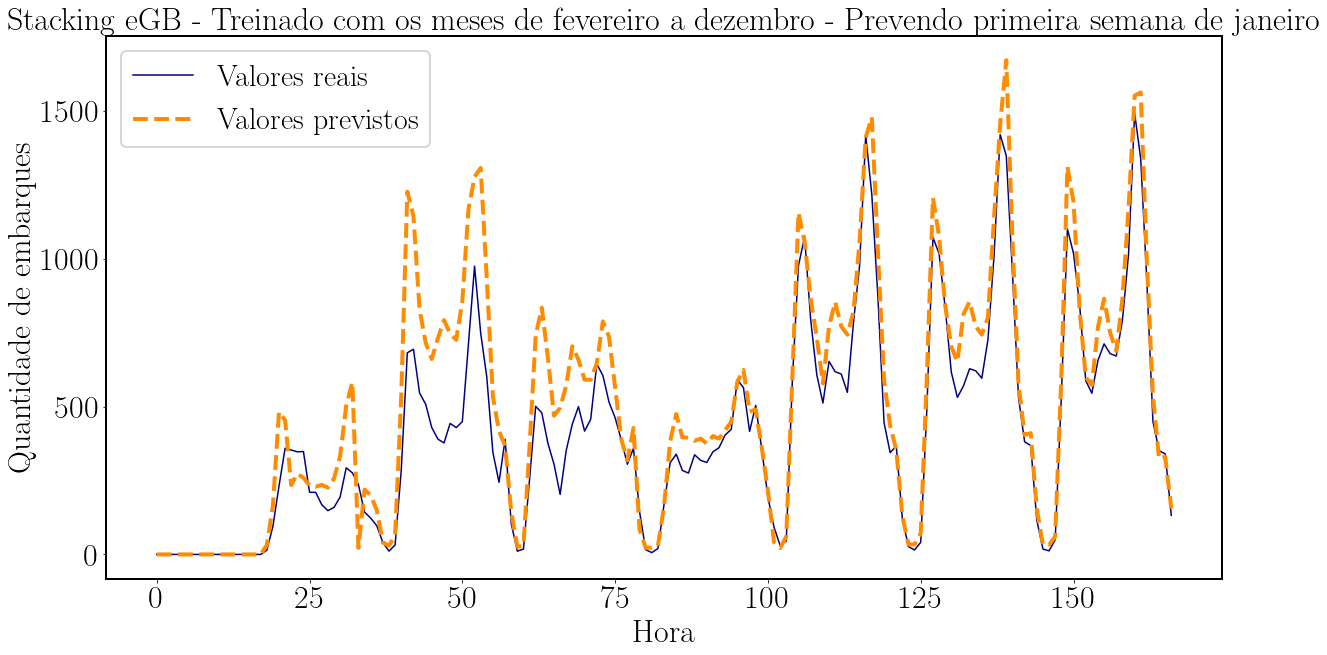

In [149]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168
# plt.rc('patch',linewidth=2)
plt.rc('axes', linewidth=2, labelpad=5)
# plt.rc('xtick.minor', size=8, width=4)
# plt.rc('ytick.minor', size=8, width=4)
# ax.set_facecolor("white")
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern', size=42)
plt.figure(figsize=(20,10))
plt.plot(range(df_predict_dados.validations_per_hour.size), df_predict_dados.validations_per_hour.values, color='navy', label="Valores reais")
plt.plot(range(predictions.__len__()), predictions, color='darkorange',linestyle='dashed', label="Valores previstos", linewidth=4)
# plt.plot(range(df_Abril_xGB.__len__()), df_Abril_xGB, color='indigo',linestyle='dashed', label="Valores previstos: Random Forest", linewidth=2)
# plt.plot(range(df_Abril_StackingA.__len__()), df_Abril_StackingA, color='rebeccapurple',linestyle='dashed', label="Valores previstos: Stacking A", linewidth=2)


# plt.xticks(range(0,24))
plt.legend(fontsize=30)
plt.xlabel('Hora', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.title("Stacking eGB - Treinado com os meses de fevereiro a dezembro - Prevendo primeira semana de janeiro", fontsize=32)
plt.ylabel('Quantidade de embarques', fontsize=32)
plt.savefig(f'../images/stacking-egb-{year}-all-predict-janeiro-w1.pdf')
plt.show()

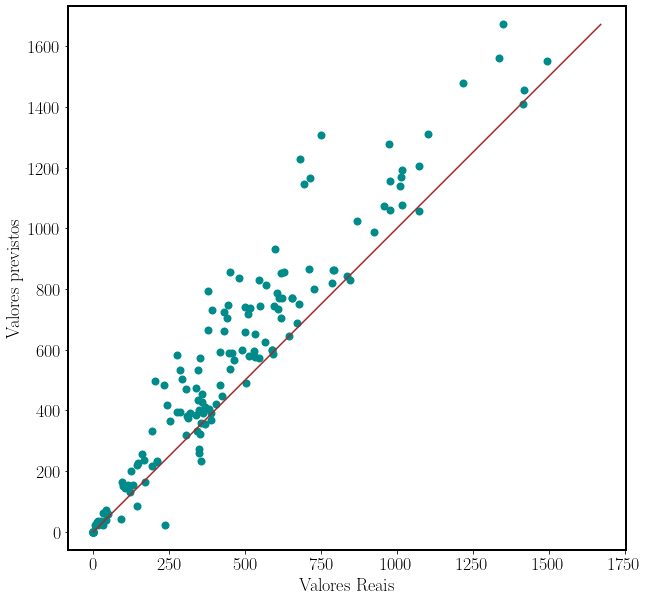

In [150]:

real_values = df_predict_dados.validations_per_hour
predictions = predictions

plt.rc('patch',linewidth=2)
plt.rc('axes', linewidth=2, labelpad=5)
plt.rc('xtick.minor', size=8, width=4)
plt.rc('ytick.minor', size=8, width=4)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern', size=18)
plt.figure(figsize=(10,10))
plt.scatter(real_values, predictions, c='darkcyan')

p1 = max(max(predictions), max(real_values.values))
p2 = min(min(predictions), min(real_values.values))
plt.plot([p1, p2], [p1, p2], 'brown')

plt.xlabel('Valores Reais', fontsize=18)
plt.ylabel('Valores previstos', fontsize=18)
plt.axis('equal')

plt.savefig(f'../images/stacking-egb-{year}-all-predict-janeiro-w1-scatterplot.pdf')
plt.show()

# Treinar com 1 mes, prever N semanas

In [ ]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

# meses_de_treino = [1,2,3]
# mes_de_previsao = 4

# line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)]

# line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

# df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  8].filter(feature_names, axis = 1)
# real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  8].validations_per_hour)

# X = line_mes_data_model.filter(feature_names, axis=1)
# y = line_mes_data_model.validations_per_hour
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

# predictions = [[],[],[],[],[]]
# performances = list()

# for i, model in enumerate(model_list):
#         model.fit(X_train, Y_train)
#         performances.append(get_performance(model))

#         for index, row in df_prev.iterrows():
#             predictions[i].append(model.predict([row])[0])


In [ ]:
# df_performance = pd.DataFrame(performances)
# df_performance.to_csv('../performances/2015/linha'+str(busline_filter)+'_'+str(meses_de_treino)+'meses_1semana('+str(mes_de_previsao)+')_performance.csv', index=False)
# df_predict_dados = real_values
# df_predict_dados['validations_per_hour_predicted'] = predictions[0]

# df_predict_dados.to_csv('../predict-vs-real/2015/linha'+str(busline_filter)+'_'+str(meses_de_treino)+'meses_1semana('+str(mes_de_previsao)+')_predict.csv', index=False)

# df_performance

In [ ]:
# # 168 == quantidade de horas previstas em 1 semana
# plt_size = 168

# plt.figure(figsize=(30, 10))
# plt.plot(range(df_predict_dados.validations_per_hour.size), df_predict_dados.validations_per_hour.values, color='blue')
# plt.plot(range(predictions[0].__len__()), predictions[0], color='red')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.show()

In [ ]:
# line_data_model.loc[line_data_model.mes == 4].loc[line_data_model.d_mes < 8]

### Treinar com (N-Y) meses, Prever mes (N)

In [ ]:
# # Jan, Fev, Mar, Abril, Maio
# # treina com mar, preve 2 semanas de abril

# meses_de_treino = [1,2,3]
# mes_de_previsao = 4
# dias_de_previsao = 7

# line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)]

# line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

# df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  dias_de_previsao+1].filter(feature_names, axis = 1)
# real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  dias_de_previsao+1].validations_per_hour)

# X = line_mes_data_model.filter(feature_names, axis=1)
# y = line_mes_data_model.validations_per_hour
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

# predictions = [[],[],[],[],[]]
# performances = list()

# for i, model in enumerate(model_list):
#         model.fit(X_train, Y_train)
#         performances.append(get_performance(model))

#         for index, row in df_prev.iterrows():
#             predictions[i].append(model.predict([row])[0])


In [ ]:
# 168 == quantidade de horas previstas em 1 semana
# plt_size = 168

# plt.figure(figsize=(30, 10))
# plt.plot(range(df_results.size), df_results.values, color='blue')
# plt.plot(range(predictions.__len__()), predictions, color='red')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.show()

In [ ]:
# performances

## Ranking Linhas de Onibus

In [ ]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
# res_map = list()
# top100_linhas = data_model.linha.value_counts().index[:100]

# for linha in top100_linhas:
#     currentLinhaData = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == linha].copy()
#     X = currentLinhaData.filter(feature_names, axis=1)
#     y = currentLinhaData.validations_per_hour
#     X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
#     for model in model_list:
#         model.fit(X_train, Y_train)
#         performance = get_performance(model)
#         performance.insert(0, linha)
#         res_map.append(performance)
# res_map = pd.DataFrame(res_map, columns=["Linha", "R2", "RMSE", "MAE", 'MAPE'])
# r = res_map.sort_values('MAE', ascending=True)
# r.to_csv("../performances/2015/ranking_top100_2015.csv", index=False)



In [ ]:
# res_map = pd.DataFrame(res_map,columns=['Linha', 
#     # '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     # '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     # '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' 
#     ])
# res_map = pd.DataFrame(res_map,columns=['Linha','R2', 'RMSE', 'MAE', 'MAPE'])

# #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
# res_map = res_map.sort_values('MAE', ascending=True).reset_index(drop=True)
# res_map = res_map.drop_duplicates(subset='Linha', keep="first").reset_index(drop=True)
# res_map.to_csv('../top100linhas_rank_2015.csv', index=False)
# res_map